In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [26]:
train = pd.read_csv("../data/TrainingData/trainingWithItems.csv",index_col=0)
train

,YEAR FORECAST MADE,QUARTER,YEAR BEING FORECAST,INDICATOR,FORECASTER ID,INDUSTRY,Year.ID.ForecastYear.Quarter,Indicator.Year.ID.ForecastYear.Quarter,BIN 1,BIN 2,...,ACTUAL_CONF,HIT,pred_average,pred_var,chicken,coffee,eggs,electricity,rice,unleadedGasoline
0,1968,4,1968,NominalGNP,1,NaN,1968-1-1968-4,NominalGNP-1968-1-1968-4,0.0,0.0,...,0.00,0.0,6.000,0.450000,NaN,NaN,NaN,NaN,NaN,NaN
1,1968,4,1968,NominalGNP,2,NaN,1968-2-1968-4,NominalGNP-1968-2-1968-4,0.0,0.0,...,0.00,0.0,6.100,1.040000,NaN,NaN,NaN,NaN,NaN,NaN
2,1968,4,1968,NominalGNP,3,NaN,1968-3-1968-4,NominalGNP-1968-3-1968-4,0.0,0.0,...,0.00,0.0,6.800,0.410000,NaN,NaN,NaN,NaN,NaN,NaN
3,1968,4,1968,NominalGNP,4,NaN,1968-4-1968-4,NominalGNP-1968-4-1968-4,0.0,0.0,...,0.00,0.0,6.150,1.327500,NaN,NaN,NaN,NaN,NaN,NaN
4,1968,4,1968,NominalGNP,5,NaN,1968-5-1968-4,NominalGNP-1968-5-1968-4,3.0,4.0,...,0.04,0.0,4.650,7.227500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36057,2021,2,2024,Unemployment,586,2.0,2024-586-2021-2,Unemployment-2024-586-2021-2,0.0,0.0,...,0.00,0.0,5.514,0.578179,1.5005,4.659,1.6225,0.1395,0.793,2.9055
36058,2021,2,2024,Unemployment,587,2.0,2024-587-2021-2,Unemployment-2024-587-2021-2,0.0,0.0,...,0.00,0.0,5.125,0.203125,1.5005,4.659,1.6225,0.1395,0.793,2.9055
36059,2021,2,2024,Unemployment,588,1.0,2024-588-2021-2,Unemployment-2024-588-2021-2,0.0,0.0,...,0.00,0.0,5.125,0.203125,1.5005,4.659,1.6225,0.1395,0.793,2.9055
36060,2021,2,2024,Unemployment,589,2.0,2024-589-2021-2,Unemployment-2024-589-2021-2,0.0,0.0,...,0.00,0.0,5.175,0.050625,1.5005,4.659,1.6225,0.1395,0.793,2.9055


In [27]:
unemp = train[train['INDICATOR'] == "Unemployment"]
rgdp = train[train['INDICATOR'] == "RealGDP"]
cpce = train[train['INDICATOR'] == "Core PCE"]
ccpi = train[train['INDICATOR'] == "Core CPI"]
ngnp = train[train['INDICATOR'] == "NominalGNP"]
rgnp = train[train['INDICATOR'] == "RealGNP"]

In [17]:
def model_setup(df):
    
    rand = df.sample(frac = 1)
    #80/20 split
    nrow = len(rand)
    
    train_prop = int(np.round(nrow*0.8))
    train = rand[:train_prop]
    val = rand[train_prop:]
    
    train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual"]]
    val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual"]]
    
    return train.dropna(), val.dropna()

In [40]:
def run_xgb_model(df, variable_name, plot=True):
    train_set, val = model_setup(train)

    X, Y = train_set[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF"]], train_set["actual"].tolist()
    val_X, val_Y = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF"]], val["actual"].tolist()

    model=xgb.XGBRegressor(verbosity=0)
    fitted = model.fit(X, Y)
    preds = model.predict(val_X)
    diffs = val_Y - predicted_values
    diffs

    r21 = np.corrcoef(val_Y, preds)[0][1]
    r22 = np.corrcoef(val_Y, np.array(val_X['pred_average'].tolist()))[0][1]

    mse1 = mean_squared_error(val_Y, preds)
    mse2 = mean_squared_error(val_Y, np.array(val_X['pred_average'].tolist()))

    if plot == True:
        print("Differences in actual vs. model prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(diffs)))
        print("Median: " + str(np.median(diffs)))
        print("Max: " + str(max(diffs)))
        print("Min: " + str(min(diffs)))
        print("Correlation Coef: " + str(r21))
        print("MSE: " + str(mse1))

        plt.hist(diffs)
        plt.title("Actual minus Model Prediction (" + variable_name + ")")
        plt.show()

        actual_diffs = np.subtract(val_Y, np.array(val_X['pred_average'].tolist()))
        print("Differences in actual vs. forecaster average prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(actual_diffs)))
        print("Median: " + str(np.median(actual_diffs)))
        print("Max: " + str(max(actual_diffs)))
        print("Min: " + str(min(actual_diffs)))
        print("Correlation Coef: " + str(r22))
        print("MSE: " + str(mse2))

        plt.hist(actual_diffs)
        plt.title("Actual Rate minus Forecaster Average Prediction (" + variable_name + ")")
        plt.show()

    else:
        return mse1, mse2, r21, r22

Differences in actual vs. model prediction (Unemployment)
Mean: 0.00552645983852906
Median: -0.03204310902654761
Max: 15.5306915914917
Min: -15.49686962677002
Correlation Coef: 0.9275567933383105
MSE: 1.2843785430347194


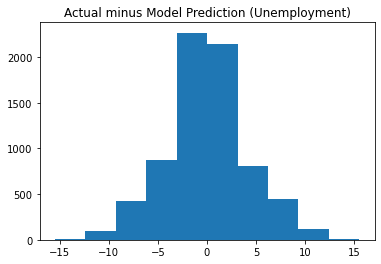

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -0.26962294956236865
Median: -0.18732000000000015
Max: 10.97415
Min: -8.2875
Correlation Coef: 0.8064049244138367
MSE: 3.2993752859912036


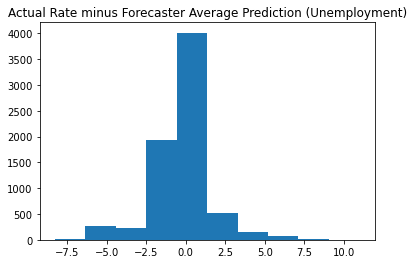

Differences in actual vs. model prediction (RealGDP)
Mean: -0.028547135049122728
Median: -0.076977139854431
Max: 14.296030893554688
Min: -15.548491063842773
Correlation Coef: 0.9293794988028992
MSE: 1.251555028570242


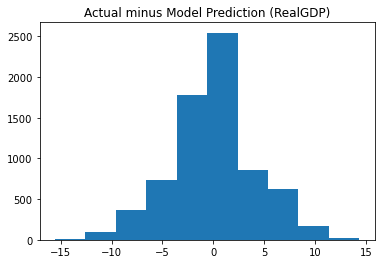

Differences in actual vs. forecaster average prediction (RealGDP)
Mean: -0.2680790859685023
Median: -0.1844269999999999
Max: 9.618333
Min: -7.81076
Correlation Coef: 0.8019818079051827
MSE: 3.3551541793237543


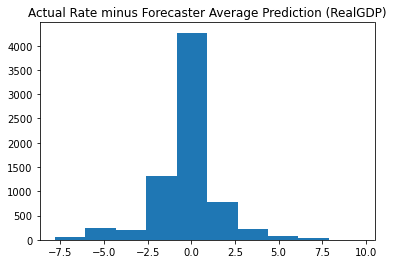

Differences in actual vs. model prediction (Core PCE)
Mean: -0.03775229651822266
Median: -0.08826616168770851
Max: 15.523534522399903
Min: -15.46058518005371
Correlation Coef: 0.9187754524758528
MSE: 1.4340998757557932


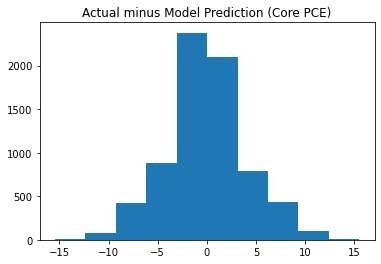

Differences in actual vs. forecaster average prediction (Core PCE)
Mean: -0.25829061277103665
Median: -0.1773754999999999
Max: 11.024149999999999
Min: -8.629427473536666
Correlation Coef: 0.7870341816025371
MSE: 3.58863626178755


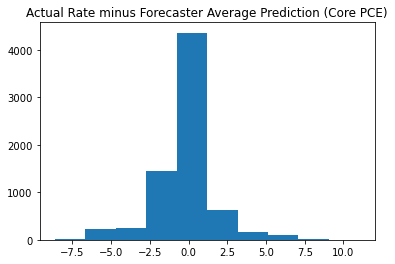

Differences in actual vs. model prediction (Core CPI)
Mean: 0.0016670111369541025
Median: -0.02905021115351797
Max: 15.675486294021606
Min: -15.685674253234863
Correlation Coef: 0.9276734366659078
MSE: 1.2501539384649865


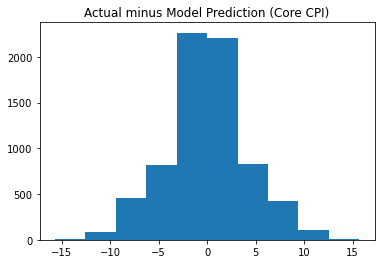

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: -0.23294712726577446
Median: -0.17444295034271007
Max: 9.294740000000001
Min: -8.629427473536666
Correlation Coef: 0.8028810772593076
MSE: 3.2585680897376186


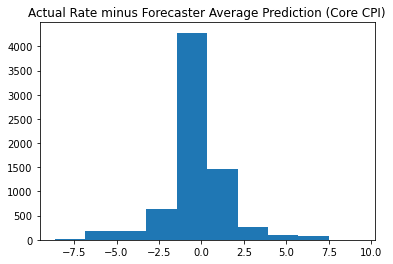

Differences in actual vs. model prediction (NominalGNP)
Mean: -0.01992672123376128
Median: 0.012889664347382812
Max: 15.499554291000367
Min: -15.779932561645508
Correlation Coef: 0.9265911308155499
MSE: 1.277276851265068


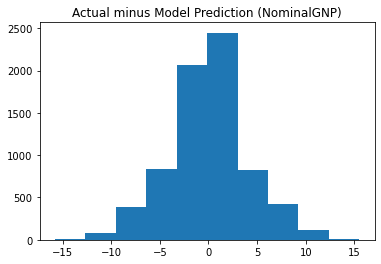

Differences in actual vs. forecaster average prediction (NominalGNP)
Mean: -0.25121453055218623
Median: -0.17135000000000034
Max: 10.378333
Min: -8.5975
Correlation Coef: 0.797637041614741
MSE: 3.365002614632422


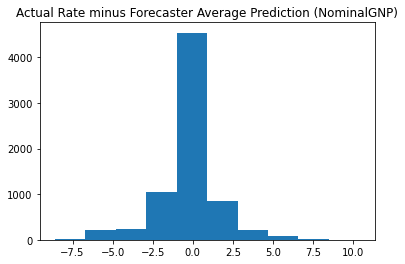

Differences in actual vs. model prediction (RealGNP)
Mean: -0.03252557017434023
Median: -0.05751007563018806
Max: 14.465402613067626
Min: -15.17822605682373
Correlation Coef: 0.9258834088760404
MSE: 1.2769901750660335


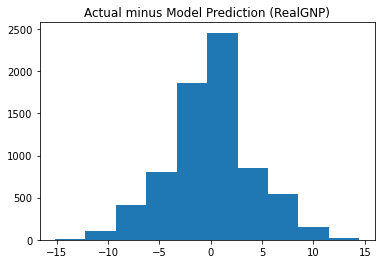

Differences in actual vs. forecaster average prediction (RealGNP)
Mean: -0.2725522488943152
Median: -0.19504
Max: 9.03743
Min: -8.82417
Correlation Coef: 0.7968337645399018
MSE: 3.3697505551961524


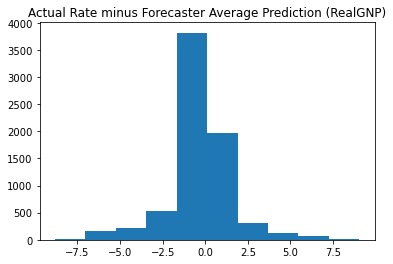

In [41]:
for variable, name in zip([unemp,rgdp,cpce,ccpi,ngnp,rgnp],["Unemployment","RealGDP","Core PCE","Core CPI","NominalGNP","RealGNP"]):
    run_xgb_model(variable,name)

In [47]:
def evaluate():
    mse1s = []
    mse2s = []
    r21s = []
    r22s = []
    for i in [unemp, rgdp, cpce, ccpi, ngnp, rgnp]:
        mse1, mse2, r21, r22 = run_xgb_model(i, "name", plot=False)
        mse1s.append(np.sqrt(mse1))
        mse2s.append(np.sqrt(mse2))
        r21s.append(r21)
        r22s.append(r22)
        
    rmse_diff = np.sqrt(np.mean(np.subtract(mse2s,mse1s)))
    r2_diff = np.mean(np.subtract(r21s, r22s))
    
    print("We decrease RMSE by " + str(rmse_diff))
    print("We increase R-squared by " + str(r2_diff))

In [48]:
evaluate()

We decrease RMSE by 0.8242179712382578
We increase R-squared by 0.12560810243757217


In [ ]:
# Do Ensemble???